In [3]:
import os
import math
import time

from PIL import Image
from config import BASE_DIR
import numpy as np
import matplotlib.pyplot as plt
from src.ml.scripts.predict import predict
from scipy.ndimage import measurements, zoom

In [4]:
image = Image.open(os.path.join(BASE_DIR, 'data/satellite_images/ld.tif'))

tile_size = 50

image_size = list(map(lambda x : math.floor(x / 50), image.size))

tiles = np.empty(image_size, dtype=object)

for i in range(0, tiles.shape[0]):
    for j in range(0, tiles.shape[1]):
        x = i * tile_size
        y = j * tile_size
        tile = image.crop((x, y, x + tile_size, y + tile_size))
        tiles[i, j] = np.array(tile)

predictions = predict('model1', tiles.flatten())

pred_map = np.array(predictions).reshape(image_size)

Using cache found in /home/witek/.cache/torch/hub/pytorch_vision_v0.10.0


/tmp/ipykernel_4399/2757601794.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  pred_map, clusters = measurements.label(pred_map)


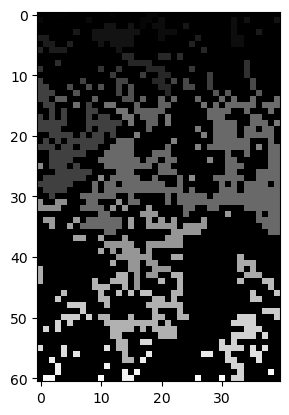

In [5]:
pred_map, clusters = measurements.label(pred_map)
plt.imshow(pred_map * 10, cmap='gray')

In [6]:
clusters_to_filter = [cluster for cluster in np.unique(pred_map) if np.count_nonzero(pred_map == cluster) <= 2]
mask = np.isin(pred_map, clusters_to_filter)
pred_map[mask] = 0
pred_mapT = pred_map.T

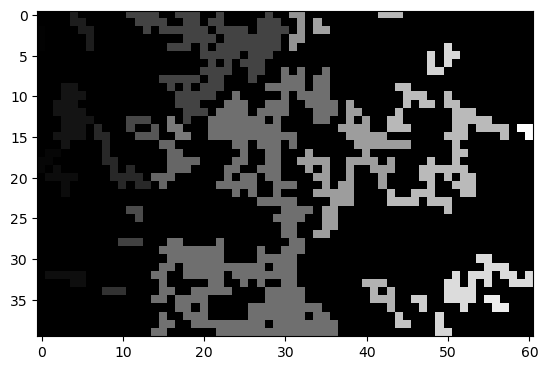

In [7]:
plt.imshow(pred_mapT, cmap='gray')

In [63]:
# SHOW MAP

for i in range(0, pred_map.shape[0]):
    for j in range(0, pred_map.shape[1]):
        x = i * tile_size
        y = j * tile_size

        if pred_map[i, j]:
            region = image.crop((x, y, x + tile_size, y + tile_size))
            red_channel = region.split()[0]
            red_channel = red_channel.point(lambda p: p * 1.5)
            new_region = Image.merge("RGB", (red_channel, region.split()[1], region.split()[2]))
            image.paste(new_region, (x, y, x + tile_size, y + tile_size))

image.show()

In [90]:
areas = {i : [(x, y) for x, y in zip(np.where(pred_map == i)[0], np.where(pred_map == i)[1])] for i in np.unique(pred_map)[1:]}
areas

{1: [(0, 2), (0, 3), (0, 4)],
 3: [(0, 18), (0, 19), (1, 17), (1, 18), (2, 17)],
 6: [(1, 20), (2, 19), (2, 20), (3, 20), (3, 21), (3, 22), (4, 20)],
 7: [(1, 32), (2, 32), (3, 32), (4, 32), (4, 33), (5, 32), (5, 33)],
 10: [(2, 11),
  (2, 12),
  (2, 15),
  (3, 9),
  (3, 10),
  (3, 11),
  (3, 12),
  (3, 13),
  (3, 14),
  (3, 15),
  (3, 16),
  (4, 9),
  (4, 10),
  (4, 11),
  (4, 12),
  (4, 13),
  (4, 14),
  (4, 15),
  (5, 10),
  (5, 12),
  (5, 13),
  (5, 14),
  (5, 15),
  (6, 13)],
 14: [(4, 0), (4, 1), (5, 1), (5, 2), (6, 2), (6, 3), (6, 4)],
 20: [(7, 14),
  (7, 15),
  (8, 15),
  (8, 16),
  (8, 17),
  (8, 18),
  (9, 18),
  (9, 19),
  (9, 20),
  (10, 20),
  (10, 21),
  (11, 19),
  (11, 20),
  (12, 20),
  (12, 21),
  (13, 21)],
 24: [(8, 34), (9, 34), (10, 34)],
 31: [(10, 28), (11, 28), (12, 28)],
 32: [(11, 0),
  (12, 0),
  (12, 1),
  (13, 0),
  (13, 1),
  (13, 2),
  (14, 0),
  (14, 1),
  (15, 1),
  (15, 2),
  (15, 8),
  (16, 2),
  (16, 4),
  (16, 8),
  (16, 9),
  (17, 0),
  (17, 2),


In [91]:
for key in areas.keys():
    row = areas[key]
    new_row = []
    for x in row:
        new_row.extend([(x[0], x[1]), (x[0] + 1, x[1]), (x[0], x[1] + 1), (x[0] + 1, x[1] + 1)])
    areas[key] = list(set(new_row))

areas

{1: [(1, 2), (0, 4), (1, 5), (0, 3), (1, 4), (0, 2), (0, 5), (1, 3)],
 3: [(1, 18),
  (0, 20),
  (2, 17),
  (3, 17),
  (0, 19),
  (1, 20),
  (2, 19),
  (1, 17),
  (2, 18),
  (0, 18),
  (3, 18),
  (1, 19)],
 6: [(5, 21),
  (4, 23),
  (1, 21),
  (2, 20),
  (3, 23),
  (4, 22),
  (3, 20),
  (1, 20),
  (2, 19),
  (5, 20),
  (4, 21),
  (3, 19),
  (3, 22),
  (2, 21),
  (3, 21),
  (4, 20)],
 7: [(2, 33),
  (5, 34),
  (3, 33),
  (6, 34),
  (4, 32),
  (5, 33),
  (6, 33),
  (1, 33),
  (2, 32),
  (5, 32),
  (4, 34),
  (3, 32),
  (6, 32),
  (1, 32),
  (4, 33)],
 10: [(6, 12),
  (6, 15),
  (4, 9),
  (4, 12),
  (3, 10),
  (3, 16),
  (5, 13),
  (4, 15),
  (3, 13),
  (5, 10),
  (5, 16),
  (2, 11),
  (6, 11),
  (6, 14),
  (7, 13),
  (3, 9),
  (4, 14),
  (3, 12),
  (5, 9),
  (4, 11),
  (4, 17),
  (3, 15),
  (5, 12),
  (5, 15),
  (2, 16),
  (2, 13),
  (6, 13),
  (6, 10),
  (6, 16),
  (3, 11),
  (4, 10),
  (4, 16),
  (3, 14),
  (5, 11),
  (4, 13),
  (3, 17),
  (5, 14),
  (2, 12),
  (2, 15),
  (7, 14)],
 14

In [11]:
areas[113]

[(56, 36),
 (57, 36),
 (58, 36),
 (56, 35),
 (57, 35),
 (55, 36),
 (56, 37),
 (55, 35),
 (57, 37),
 (58, 37)]

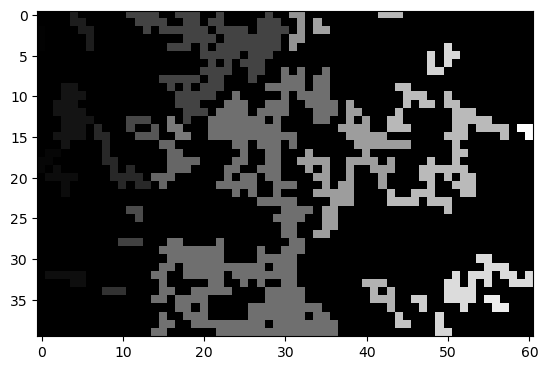

In [12]:
plt.imshow(pred_mapT, cmap='gray')

In [13]:
nmap = zoom(pred_mapT, tile_size, order=0)
nmap[nmap != 0] = 255

In [126]:
import cv2

window_size = 100

areass = [tile_size * np.array(areas[area]) for area in areas.keys()]
new_areas = []

for i in range(0, image.size[0], window_size):
    for j in range(0, image.size[1], window_size):
        
        for area in areass:
            new_area = []
            new_area = [x for x in area if i <= x[0] <= i + window_size and j <= x[1] <= j + window_size]
            if len(new_area):
                new_areas.append(new_area)
            
new_areas = [cv2.convexHull(np.array(area)) for area in new_areas]
new_areas = [np.array([x[0]for x in area]) for area in new_areas]

In [127]:
from numba import jit

@jit(nopython=True)
def is_inside(x, y, poly):
    n = len(poly)
    inside = False
    xints = 0.0
    p1x, p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside


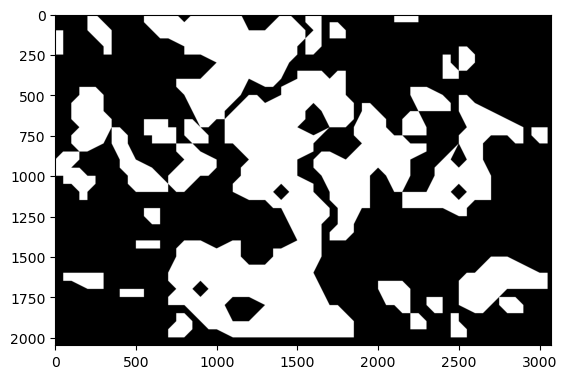

In [128]:
map = np.zeros(image.size)

for i in range(map.shape[0]):    
    for j in range(map.shape[1]):
        
        for area in new_areas:
            if is_inside(i, j, area):
                map[i, j] = 200
                
plt.imshow(map.T, cmap='gray')

In [129]:
result = np.stack((map.T, np.array(image.split()[1]), np.array(image.split()[2])), axis=0)
result = result.T.astype('uint8')
result = np.transpose(result, (1, 0, 2))
result = Image.fromarray(result)
result.show()


(eog:6487): EOG-WARNING **: 14:16:39.539: Thumbnail creation failed
